# Model architecture
Model architecture was the same for all trained agents. It's defined in `model.py`. It consists of 37 input neurons (one for each dimension of state-space), 2x64 in hidden layers and 4 output neurons (one for each available action). ReLU activation function is used on the hidden layers.


# Learning algorithm
Learning algorithms are defined in `dqn_agent.py`(basic DQN), `double_dqn_agent.py`(Double DQN), `per_dqn_agent.py`(Prioritized Experience Replay DQN) and `per_double_dqn_agent.py`(Combination of all three). For all algorithms the replay buffer size was 10 000, batch size was 64, gamma was 0.99, soft update of target weights coefficient was 0.001, every four steps in the environment the local network was learning and soft updating target weights, learning rate was 0.0005.

### DQN
With each step in the envrionment the SARS tuple was added to the memory. Agent acts in the environment using its epsilon greedy policy (using the local network). Every 4 steps (after the whole memory was filled) the algorithm takes a random sample batch of experience from the memory and learns on it. For each experience it calculates the target return (current reward plus discounted future rewards obtained by getting the highest Q-value from the target network for a given state) and current return (Q-value from the local network for a given state and action). Then it calculates the Mean Square Error and runs the backpropagation. After that it soft-updates target network's weights.

### Double DQN
Most of the algorithm stays the same as in DQN except for Q-values calculation. Previously the action that maximizes the result for a given state was selected using the same network (target network) that was used to obtain the result itself. This could lead to overestimating Q-value. To combat this we can use a different network (in this case the local network) to choose an action that maximizes the result for a given state and a second network (in this case target network) to calculate the result based on the action and the state. This prevent propagating incidental higher rewards that could be obtained by chance.

### Prioritized Experience Replay DQN
Again, most of the algorithm stays the same as in DQN except for the replay buffer (and learning). Previously we chose sample experiences using the uniform distribution. Prioritized Experience Replay is based on a idea that some experiences are more valuable than others and should be repeated more often. In this case, each expererience has a priority $p_i$ assigned to it which is an absolute value of the temporal difference error plus some small positive constant (to prevent the situation when the priority is 0). Then the sampling probability for a given experience $p_i$ is equal to: 
$$
P(i)=\frac{p_{i}^{a}}{\sum_{k=1}^{n} p_{k}^{a}}
$$
where $a\in \mathbb{R} \wedge 0<=a<=1$ is a hyperparameter controling how much sampling probability depends on priority, where $a=0$ means uniform sampling and $a=1$ means sampling using only priority, and $n$ is the batch size. In this case the best results were obtained for $a=0.1$. In the implemention I used Sum Tree structure as a replay buffer for the optimal performance.
Because the underlying distribution the experiences come from was changed we also need to change the way we update the weights. We multiply the weight change by the importance-sampling weight:
$$
(n\bullet P(i))^{-b}
$$
where $b\in \mathbb{R} \wedge 0<=b<=1$ is a hyperparameter controlling how much this weight affects learning. In this case $b=0.2$ and is increased by 0.001 with each learning step.

### Prioritized Experience Replay Double DQN
This algorithm is almost the same as Prioritized Experience Replay DQN but uses Q-values calculation from Double DQN.

# Plots of rewards
Yellow line indicates solving threshold (score >= 13). Blue graph is the raw score data for each episode. Red graph is a 100 episode rolling average.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
scores = pd.read_csv("run_data/scores.csv")
scores = scores.set_index("Episode")

### DQN

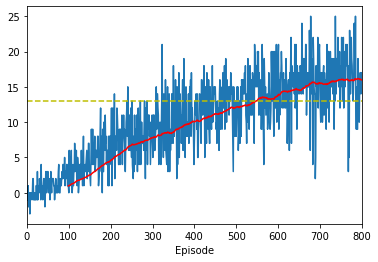

In [2]:
scores["DQN"].plot()
scores["DQN"].rolling(100).mean().plot(style="r-", xlim=(0,800))
plt.plot([0, 800], [13, 13], 'y--')

Solved in 549 episodes.

### Double DQN

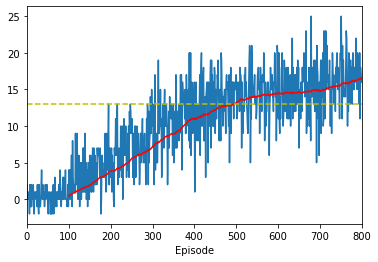

In [3]:
scores["DDQN"].plot()
scores["DDQN"].rolling(100).mean().plot(style="r-", xlim=(0,800))
plt.plot([0, 800], [13, 13], 'y--')

Solved in 497 episodes.

### Prioritized Experience Replay DQN

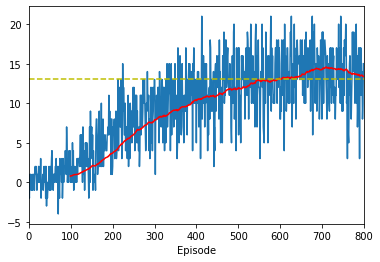

In [4]:
scores["PERDQN"].plot()
scores["PERDQN"].rolling(100).mean().plot(style="r-", xlim=(0,800))
plt.plot([0, 800], [13, 13], 'y--')

Solved in 595 episodes.
I checked with few different values of hyperparameters but it seems that still the best network is regular DQN ($a=0$). Closest one is $a=0.2\quad b=0.6\quad b_{increment}=7\bullet 10^{-6}$. With $a >= 0.4$ the agent doesn't solve the environment.

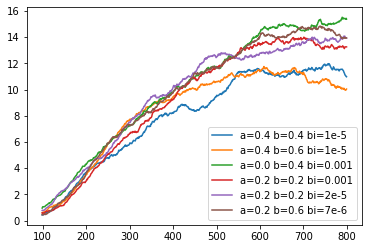

In [5]:
df1 = pd.read_csv("run_data/per_a0.4b0.4bi1e-5.csv")
df2 = pd.read_csv("run_data/per_a0.4b0.6bi1e-5.csv")
df3 = pd.read_csv("run_data/per_a0.0b0.4bi0.001.csv")
df4 = pd.read_csv("run_data/per_a0.2b0.2bi0.001.csv")
df5 = pd.read_csv("run_data/per_a0.2b0.2bi2e-5.csv")
df6 = pd.read_csv("run_data/per_a0.2b0.6bi7e-6.csv")
df1["Scores"].rolling(100).mean().plot()
df2["Scores"].rolling(100).mean().plot()
df3["Scores"].rolling(100).mean().plot()
df4["Scores"].rolling(100).mean().plot()
df5["Scores"].rolling(100).mean().plot()
df6["Scores"].rolling(100).mean().plot()
plt.legend([
    "a=0.4 b=0.4 bi=1e-5", 
    "a=0.4 b=0.6 bi=1e-5", 
    "a=0.0 b=0.4 bi=0.001", 
    "a=0.2 b=0.2 bi=0.001", 
    "a=0.2 b=0.2 bi=2e-5", 
    "a=0.2 b=0.6 bi=7e-6",
])

### Prioritized Experience Replay Double DQN

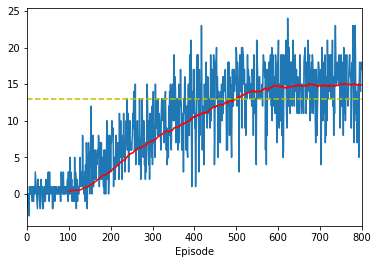

In [6]:
scores["PERDDQN"].plot()
scores["PERDDQN"].rolling(100).mean().plot(style="r-", xlim=(0,800))
plt.plot([0, 800], [13, 13], 'y--')

Solved in 502 episodes. The performance in this case is very simillar to Double DQN.

# Final thoughts and future work
We can see that Double DQN achieved the best overall perfomance after 800 episodes and learned the most quickly. Prioritized Experience Replay didn't improve the performance over the regular DQN for any hyperparameter configuration I checked.
The network could be trained a bit longer (especially Double DQN) to achieve the best performance. We could also experiment with the model architecture itself to test if changing it would improve the performance.
As to reducing the time needed to solve the environment, I think that the current solution is quite good considering the fact that it solved the environment in less than 500 episodes. That said, we could try to implement Dueling DQN together with the two other approaches to check if this algorithm learns more quickly.